In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score as ras
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('onlinefraud.csv')
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            59305 non-null  int64  
 1   type            59305 non-null  object 
 2   amount          59305 non-null  float64
 3   nameOrig        59305 non-null  object 
 4   oldbalanceOrg   59305 non-null  float64
 5   newbalanceOrig  59305 non-null  float64
 6   nameDest        59305 non-null  object 
 7   oldbalanceDest  59305 non-null  float64
 8   newbalanceDest  59305 non-null  float64
 9   isFraud         59304 non-null  float64
 10  isFlaggedFraud  59304 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 5.0+ MB


In [6]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,59305.000000,5.930500e+04,5.930500e+04,5.930500e+04,5.930500e+04,5.930500e+04,59304.000000,59304.0
mean,7.696400,1.609305e+05,7.548601e+05,7.691323e+05,8.437803e+05,1.179318e+06,0.001754,0.0
std,1.970367,3.288074e+05,2.280381e+06,2.318159e+06,2.406815e+06,2.898252e+06,0.041841,0.0
min,1.000000,6.300000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,8.361630e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,8.000000,3.838890e+04,1.789500e+04,0.000000e+00,8.171000e+03,6.924040e+03,0.000000,0.0
75%,9.000000,1.939808e+05,1.441410e+05,1.580569e+05,4.857822e+05,9.224822e+05,0.000000,0.0
max,9.000000,1.000000e+07,2.850000e+07,2.860000e+07,3.020000e+07,3.200000e+07,1.000000,0.0


In [8]:
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

int_ = (data.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (data.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))


Categorical variables: 3
Integer variables: 1
Float variables: 7


<Axes: xlabel='type', ylabel='count'>

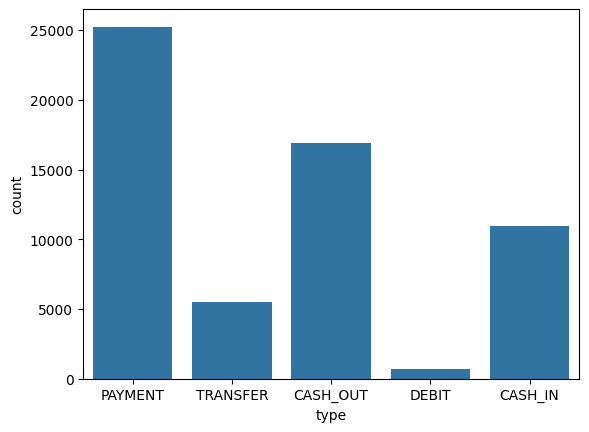

In [9]:
sns.countplot(x='type', data=data)


In [10]:
data['isFraud'].value_counts()

0.0    59200
1.0      104
Name: isFraud, dtype: int64

<ipython-input-11-d1bba932735e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['step'], bins=50)


<Axes: xlabel='step', ylabel='Density'>

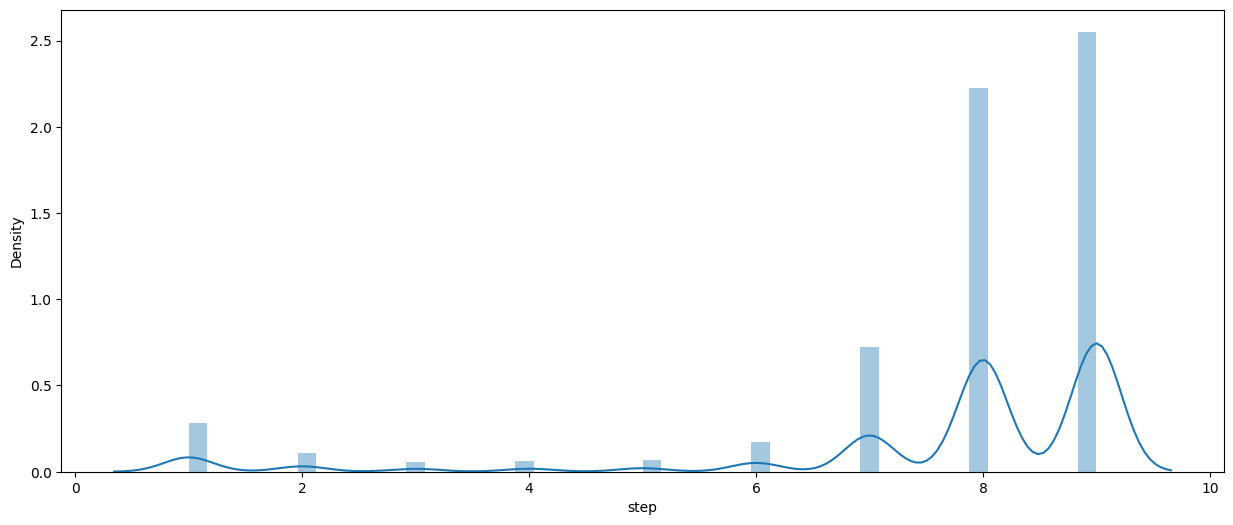

In [11]:
plt.figure(figsize=(15, 6))
sns.distplot(data['step'], bins=50)


<ipython-input-12-b69deaa7993a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),


<Axes: >

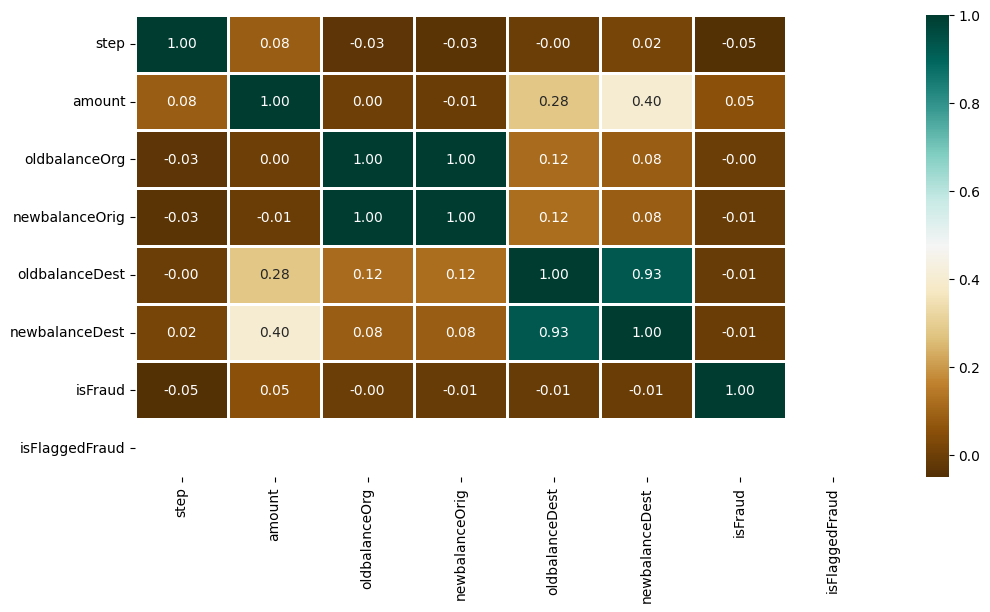

In [12]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(),cmap='BrBG',fmt='.2f',linewidths=2,annot=True)


In [13]:
# data preprocessing

type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)
data_new.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0,0,0,1,0


In [14]:
X = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = data_new['isFraud']


In [15]:
X.shape, y.shape

((59305, 11), (59305,))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [20]:
print(X_train.isnull().sum())
print(y_train.isnull().sum())
print(X_test.isnull().sum())

step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    1
CASH_OUT          0
DEBIT             0
PAYMENT           0
TRANSFER          0
dtype: int64
1
step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
CASH_OUT          0
DEBIT             0
PAYMENT           0
TRANSFER          0
dtype: int64


In [21]:
X_train = X_train.dropna()
y_train = y_train.dropna()
X_test = X_test.dropna()

In [22]:
!pip install sklearn.impute
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

ERROR: Could not find a version that satisfies the requirement sklearn.impute (from versions: none)
ERROR: No matching distribution found for sklearn.impute


In [37]:
models = [LogisticRegression(), XGBClassifier(),
		SVC(kernel='rbf', probability=True),
		RandomForestClassifier(n_estimators=7,
								criterion='entropy',
								random_state=7)]

for i in range(len(models)):
	models[i].fit(X_train, y_train)
	print(f'{models[i]} : ')

	train_preds = models[i].predict_proba(X_train)[:, 1]
	print('Training Accuracy : ', ras(y_train, train_preds))

	y_preds = models[i].predict_proba(X_test)[:, 1]
	print('Validation Accuracy : ', ras(y_test, y_preds))
	print()


LogisticRegression() : 
Training Accuracy :  0.936673587530346
Validation Accuracy :  0.9127459060450783

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.9929698471283019

SVC(probability=True) : 
Training Accuracy :  0.8895082810756579
